# BLEU (Bilingual Evaluation Understudy Score)

기계 번역(NMT)의 성능이 얼마나 뛰어난지 측정하는 대표적인 방법
- 목표 : BLEU 구현

### BLEU 요약
- 기계 번역 결과 & 사람 직접 번역의 결과가 얼마나 유사한지
- 측정 기준 : n gram에 기반
- 장점 : 언어에 구애받지 않음 / 속도 빠름 
- 높을 수록 좋은 성능

### BLEU 식

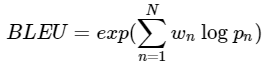

어떻게 해서 다음과 같은 식이 나오게 되었는지 알아보자

# 1. Unigram Precision (단어 개수 count로 측정)

- Ca1.Ca2 : 기계가 한->영 번역한 (영어)문장
- Ref1,Ref2,Ref3 : 사람이 한->영 번역한 (영어)문장

Ref1,2,3 중 어느 한 문장이라도 등장한 단어의 개수를 Ca1,Ca2에서 세는 것! 그 후, Ref의 모든 단어의 count의 합으로 나눔

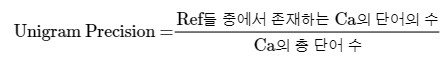

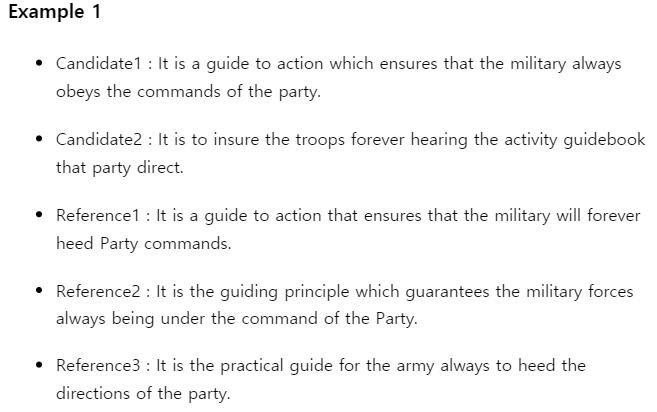

### 계산
- Ca1 문장의 18단어 중, 하나만을 제외하고 17단어가 Ref1,Ref2,Ref3 중 하나에 포함되어 있음!
- 따라서 Ca1의 Unigram Precision은 17/18

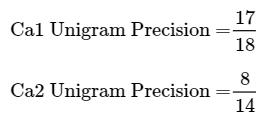

#### BUT 이 방법에는 단점이 있음. 아래를 통해서 확인!

# 2. Modified Unigram Precision

"중복을 제거함으로써 보정하기"

#### Unigram Precision의 문제점?
- 아래와 같은 Candidate문장은, 번역에 실패했음에도 불구하고 BLEU score=1로 최고의 평가를 받는다

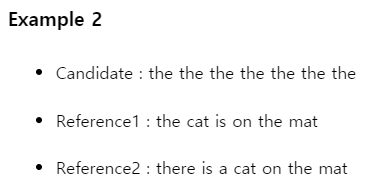

즉, Ca와 여러 Ref를 고려한 새로운 count 방법이 필요하다. 그래서 분자를 아래와 같이 수정한다

count값 대신, " min(count, 최대로 많이 등장한 ref에서의 count) "

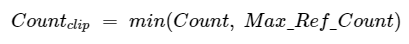

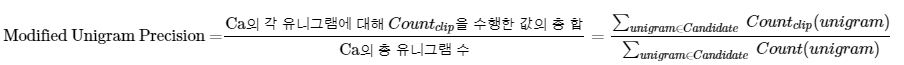

위 Example 2)에 적용하여 풀어보면
- Ref1에 the가 2번 등장 -> the의 count는 2로 보정
- 7/7=1 에서 2/7로 수정됨!

# 3. Modified Unigram Precision 구현

In [2]:
from collections import Counter
import numpy as np
from nltk import ngrams

- token 속의 ngram을 Count해주는 함수

In [3]:
def simple_count(tokens,n):
    return Counter(ngrams(tokens,n))

In [10]:
ngrams('I want rice with kimchi',2)

<generator object ngrams at 0x00000229A2479518>

In [9]:
Counter(ngrams('I want rice with kimchi',2))

Counter({('I', ' '): 1,
         (' ', 'w'): 2,
         ('w', 'a'): 1,
         ('a', 'n'): 1,
         ('n', 't'): 1,
         ('t', ' '): 1,
         (' ', 'r'): 1,
         ('r', 'i'): 1,
         ('i', 'c'): 1,
         ('c', 'e'): 1,
         ('e', ' '): 1,
         ('w', 'i'): 1,
         ('i', 't'): 1,
         ('t', 'h'): 1,
         ('h', ' '): 1,
         (' ', 'k'): 1,
         ('k', 'i'): 1,
         ('i', 'm'): 1,
         ('m', 'c'): 1,
         ('c', 'h'): 1,
         ('h', 'i'): 1})

### Example

In [11]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."

tokens = candidate.split()
result = simple_count(tokens, 1) # n=1 : Unigram

In [12]:
print(result)

Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [13]:
candidate2 = 'the the he he the the the'

tokens2 = candidate2.split() 
result2 = simple_count(tokens2, 1)

In [14]:
result2

Counter({('the',): 5, ('he',): 2})

### Count_clip : 단순 count 대신 modified count!

In [15]:
def count_clip(ca,ref_list,n):
    ca_cnt = simple_count(ca,n)
    temp= dict()
    
    for ref in ref_list:
        ref_cnt = simple_count(ref,n)
        
        for n_gram in ref_cnt:
            if n_gram in temp:
                temp[n_gram] = max(ref_cnt[n_gram], temp[n_gram])
            else:
                temp[n_gram] = ref_cnt[n_gram]
    
    return {n_gram:min(ca_cnt.get(n_gram,0),temp.get(n_gram,0))
           for n_gram in ca_cnt}

In [16]:
ca = 'the the the the the the the'

ref_list = [
    'the cat is on the mat',
    'there is a cat on the mat'
]

In [17]:
result = count_clip(ca.split(), list(map(lambda ref: ref.split(), ref_list)),1)
print(result)

{('the',): 2}


### Modified Precision

In [18]:
def mod_precision(ca,ref_list,n):
    # 분자
    clip = count_clip(ca,ref_list,n)
    total_clip = sum(clip.values())
    
    # 분모
    ct = simple_count(ca,n)
    total_ct = sum(ct.values())
    
    if total_ct ==0:
        total_ct=1
    
    return (total_clip/total_ct)        

In [19]:
result3 = mod_precision(ca.split(),list(map(lambda ref: ref.split(), ref_list)),1)

In [20]:
result3

0.2857142857142857

# 4. N-gram
- "순서 고려" 위해 Unigram -> N-gram으로 확장

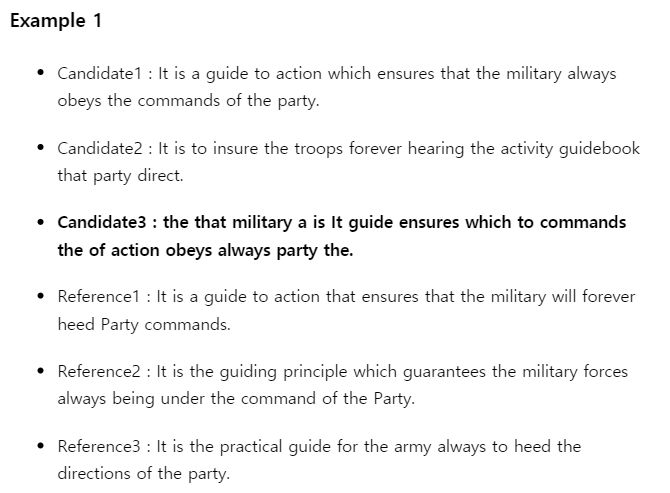

- 위 예시에서 Candidate3는 Candidate1과 정밀도가 같지만, 실제로는 어순에 맞지 않은 형편없는 문장! 
- 그러므로 N-gram을 이용한 정밀도 도입! 

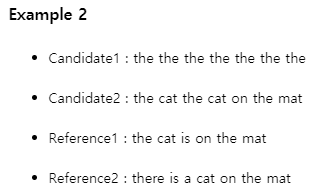

### Candidate 2의 Bi-gram 표
 - Bi-gram 정확도는 4/6이 된다

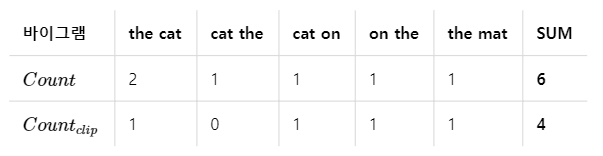

# 5. BLEU의 일반화 식

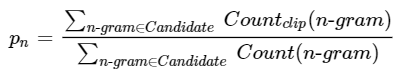

p1은 Unigram의 , p2는 Bigram의, .... pn은 N-gram의 precision score이다

이를 모두 조합하여 사용하면 최종적인 BLEU 식이 나온다

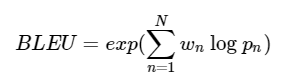

# 6. Brevity Penalty
- 짧은 문장 길이에 대해 penalty를 부여하는 것
- n-gram만으로 완벽해결? NO! 
- 이유 : 문장 길이에 따라 BLEU의 점수가 영향을 받을 수 있으므로!

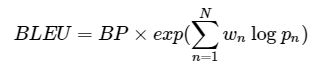

BP의 식은 다음과 같다 (Penalty를 주지 않으면, 위 식에서 BP는 1이다)

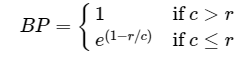

- c : Candidate의 길이
- r : Candidate와 가장 길이 차이가 작은 Reference의 길이

####  가장 길이 차이가 작은 Ref의 길이

In [21]:
def close_ref(candidate,reference_list):
    ca_len = len(candidate)
    ref_lens = (len(ref) for ref in reference_list)
    closest_len = min(ref_lens, key=lambda ref_len : (abs(ref_len-ca_len), ref_len))
    return closest_len

#### brevity penalty

In [22]:
def brevity_penalty(candidate, reference_list):
    ca_len = len(candidate)
    ref_len = close_ref(candidate,reference_list)
    if ca_len > ref_len:
        return 1
    elif ca_len == 0:
        return 0
    else :
        return np.exp(1-ref_len/ca_len)

### 최종적인 BLEU score

In [30]:
def BLEU(candidate,reference_list, weights=[0.25,0.25,0.25,0.25]):
    bp = brevity_penalty(candidate, reference_list)
    p_n = [mod_precision(candidate,reference_list,n=n) for n,_ in enumerate(weights,start=1)]
    score = np.sum([w_i*np.log(p_i) if p_i!=0 else 0 for w_i, p_i in zip(weights,p_n)])
    return bp*np.exp(score)

# 7. NLTK의 bleu

In [24]:
import nltk.translate.bleu_score as bleu

In [25]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'

references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

In [26]:
print(bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

0.5045666840058485


In [31]:
BLEU(candidate.split(), list(map(lambda ref: ref.split(), references)))

0.5045666840058485